## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.utils.mem import *
from fastai.callbacks import *

import os
import torchvision
from torchvision.utils import save_image

from torchvision.models import vgg16_bn

In [3]:
import DAT259.setup as setup
import DAT259.wgan as wgan
import DAT259.superresgan as superres
import DAT259.segmentation as seg

# Setup

### Create a new project directory

In [4]:
project_name = 'test'
path_new_project = Path('Projects/' + project_name)

setup.create_folder(Path('Projects'))
setup.create_folder(path_new_project)

### Create testset and available training data

In [5]:
path_mask = Path('data/ISIC2018_Task1_Training_GroundTruth')
path_img = Path('data/ISIC2018_Task1-2_Training_Input')

In [6]:
train, test = setup.split_train_test(path_img, path_mask, 100)

### Save testset and available training data

In [7]:
path_data = Path(str(path_new_project) + '/data')
setup.create_folder(path_data)

In [8]:
train.to_csv(str(path_data) + '/available_training_data.csv')
test.to_csv(str(path_data) + '/test_data.csv')

# Generate masks

### Directory for generated masks

In [9]:
path_gen = Path(str(path_new_project) + '/generator')
setup.create_folder(path_gen)

### Get available training data

In [10]:
available_training_data = pd.read_csv(Path(str(path_data) + '/available_training_data.csv'), index_col = 0)
available_training_data.head()

,Image,Mask
0,ISIC_0001103.jpg,ISIC_0001103_segmentation.png
1,ISIC_0012836.jpg,ISIC_0012836_segmentation.png
2,ISIC_0000409.jpg,ISIC_0000409_segmentation.png
3,ISIC_0014944.jpg,ISIC_0014944_segmentation.png
4,ISIC_0009982.jpg,ISIC_0009982_segmentation.png


### Get trainingset with num_training_data masks

In [11]:
num_training_data = 100
training_data = available_training_data.sample(num_training_data)
print (len(training_data))
training_data.head()

100


,Image,Mask
171,ISIC_0013458.jpg,ISIC_0013458_segmentation.png
9,ISIC_0010497.jpg,ISIC_0010497_segmentation.png
215,ISIC_0013197.jpg,ISIC_0013197_segmentation.png
218,ISIC_0000378.jpg,ISIC_0000378_segmentation.png
292,ISIC_0010861.jpg,ISIC_0010861_segmentation.png


Save the dataframe with training data:

In [12]:
training_data.to_csv(str(path_data) + '/training_data_' + str(num_training_data) + '.csv')

### Generate masks

Get the training data from file:

In [13]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)
training_data.head()

,Image,Mask
171,ISIC_0013458.jpg,ISIC_0013458_segmentation.png
9,ISIC_0010497.jpg,ISIC_0010497_segmentation.png
215,ISIC_0013197.jpg,ISIC_0013197_segmentation.png
218,ISIC_0000378.jpg,ISIC_0000378_segmentation.png
292,ISIC_0010861.jpg,ISIC_0010861_segmentation.png


Generate mask:

In [14]:
num_mask_to_gen = 100
path_gen_masks = Path(str(path_gen) + '/generated_masks_' + str(num_mask_to_gen))
wgan.generate_masks(training_data, num_mask_to_gen, path_mask, path_gen_masks, epochs=1, bs=50) 

In [15]:
wgan.image_cleaner(str(path_gen_masks))

## Pretraining

In [16]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.801685,97.068466,31.941891,1.184012,1.952726,0.160687,23.362207,38.283447,0.183496,00:29


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,41.105640,4.508979,0.749430,0.346698,0.429731,0.125800,1.134483,1.600716,0.122121,00:24


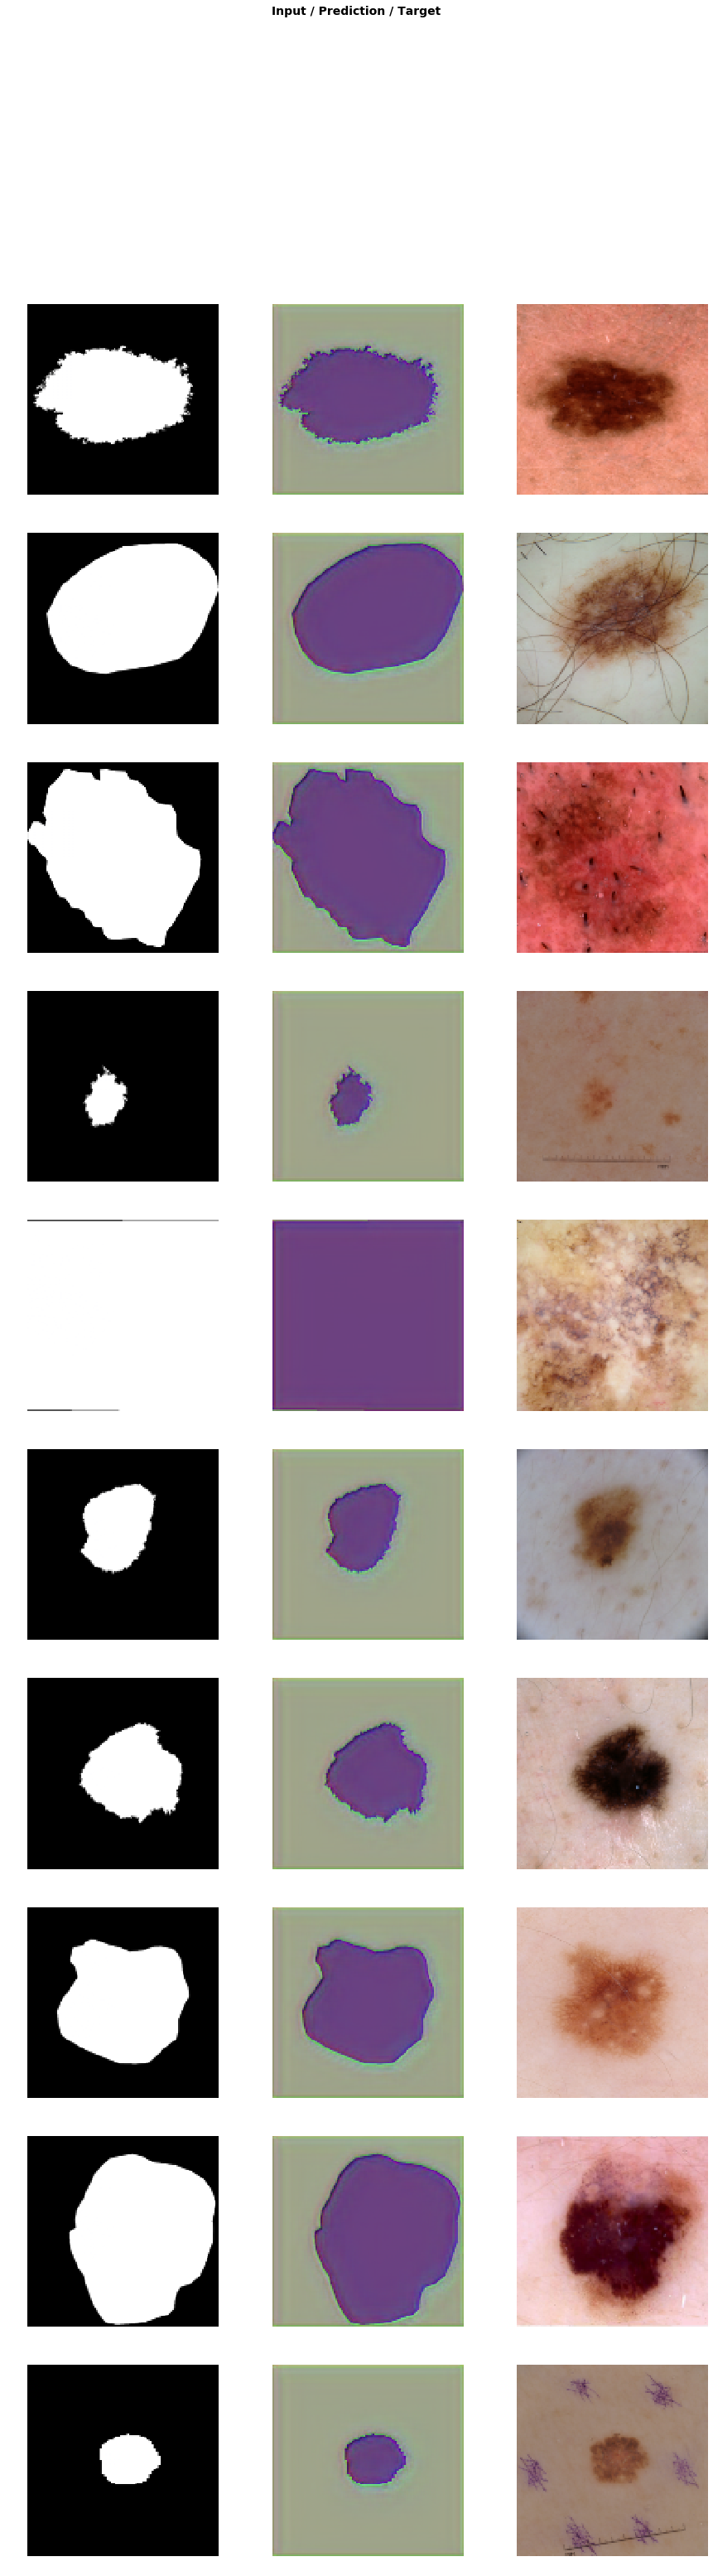

In [17]:
path_pretrained_masks = Path(str(path_gen) + '/pretrained_images_' + str(num_mask_to_gen))

learn = superres.train_generator(training_data, path_mask, path_img, path_pretrained_masks, num_epochs=1)

In [18]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
superres.train_critic(100, Path('data'), path_gen, num_epochs=1)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.766783,0.535204,0.627857,00:24


## Train GAN

In [19]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)
training_data.head()

,Image,Mask
171,ISIC_0013458.jpg,ISIC_0013458_segmentation.png
9,ISIC_0010497.jpg,ISIC_0010497_segmentation.png
215,ISIC_0013197.jpg,ISIC_0013197_segmentation.png
218,ISIC_0000378.jpg,ISIC_0000378_segmentation.png
292,ISIC_0010861.jpg,ISIC_0010861_segmentation.png


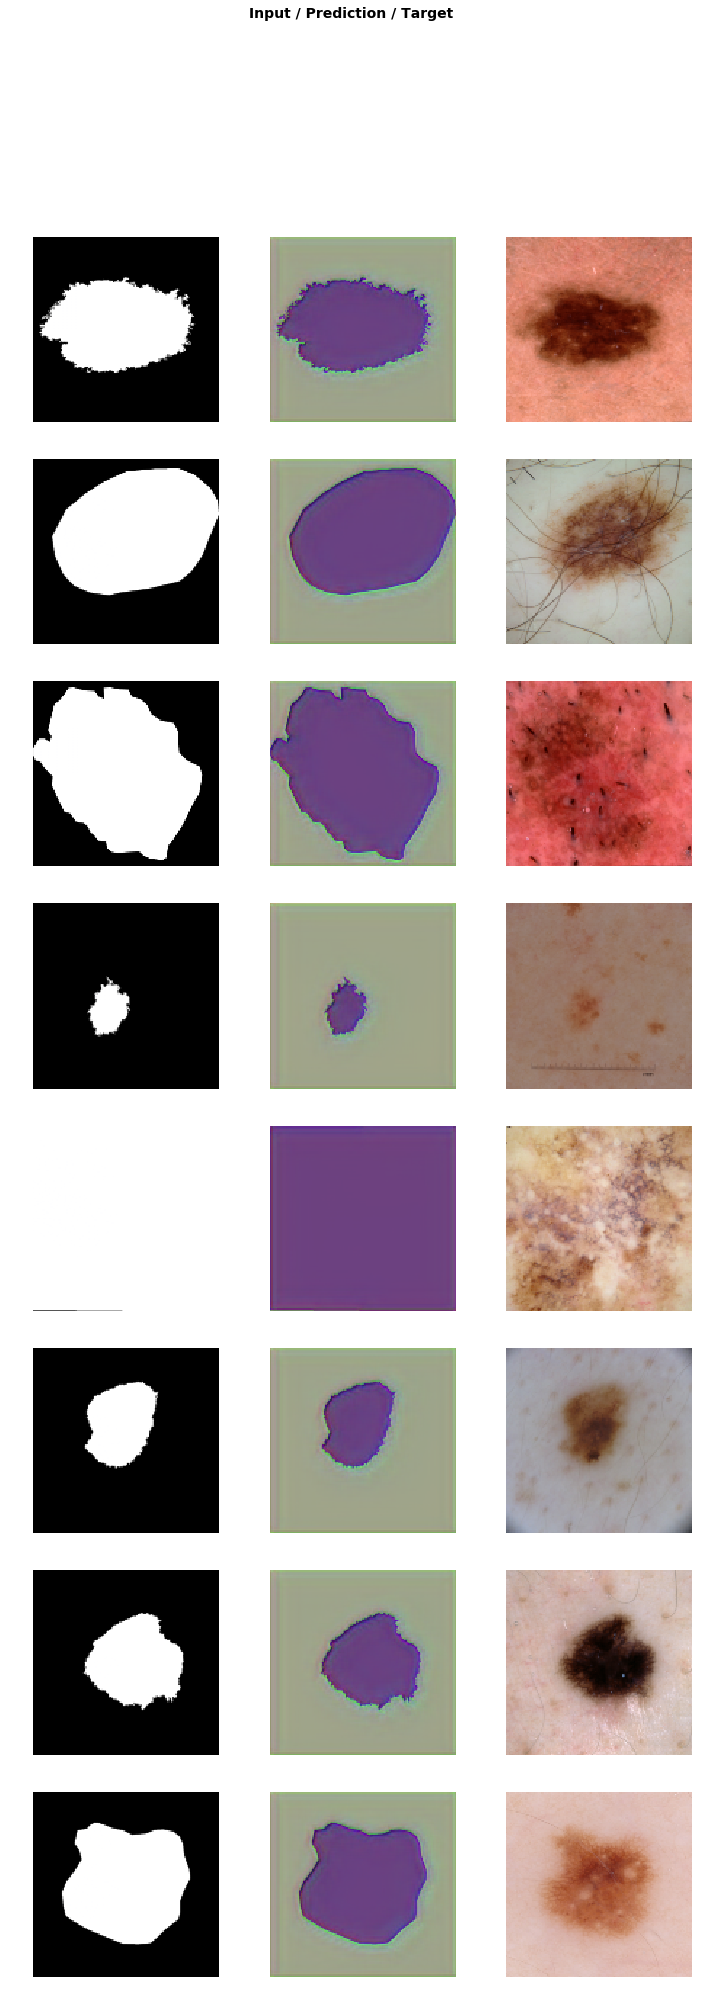

In [20]:
learn_generator = superres.train_gan(training_data, path_mask, path_img, num_epochs=1)

### Generate images

In [21]:
path_gen_images = str(path_gen) + '/generated_images_' + str(num_mask_to_gen)
setup.create_folder(path_gen_images)

In [22]:
superres.pred_gan(learn_generator, path_gen_masks, path_gen_images, num_mask_to_gen)

# Segmentation

### Resize testset

In [23]:
path_test = Path(str(path_new_project) + '/test')
setup.create_folder(path_test)

In [24]:
test_data = pd.read_csv(Path(str(path_data) + '/test_data.csv'), index_col = 0)

In [25]:
#images
img_size = 128
folder_name = 'test_img_' + str(img_size)
from_path = 'data/' + folder_name + '/'
to_path = Path(str(path_test) + '/' + folder_name)
test_img = test_data['Image']

seg.resize_img_folder(path_img, to_path, img_size, test_img)

In [56]:
#masks
img_size = 128
folder_name = 'test_mask_' + str(img_size)
from_path = 'data/' + folder_name + '/'
to_path = Path(str(path_test) + '/' + folder_name)
test_mask = test_data['Mask']

seg.resize_img_folder(path_mask, to_path, img_size, test_mask)

### Experiment1

In [ ]:
num_org_data = [100]
num_gen_data = [100, 0]

In [ ]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)

In [19]:
the_list = [100]

for i in the_list:
    num_of_org_data = str(i)
    

    # loop for segmentation using different amount of generated data 
    from_ISIC = setup.get_data(Path('data/csv/csv_' + num_of_org_data))
    path = 'data/'
    gen_img_folder = 'generated_img_'+ num_of_org_data
    gen_mask_folder = 'generated_mask_' + num_of_org_data
    test_list = [100, 0]

    for i in range(len(test_list)):

        # creating dataframes for the orginal dataset and the generated data
        number_of_generated_data = test_list[i]
        df = seg.merge_df(path, gen_img_folder, gen_mask_folder, from_ISIC, number_of_generated_data)

        # creating data for model training
        data = seg.data_mix(path, df)

        #create learner
        learner = seg.create_learner(data)

        #Training and saving the segmentation model
        model_name = 'seg_'+ num_of_org_data+ '_' + str(number_of_generated_data)
        if (os.path.isdir('data/models/segmentation_models')==False): os.mkdir('data/models/segmentation_models')
        if (os.path.isdir('data/models/segmentation_models/' + num_of_org_data)==False): os.mkdir('data/models/segmentation_models/' + num_of_org_data)
        #Se på dette!
        if (os.path.isdir('data/predictions')==False): os.mkdir('data/predictions')
        if (os.path.isdir('data/predictions/' + num_of_org_data)==False): os.mkdir('data/predictions/' + num_of_org_data)
        full_model_path = 'segmentation_models/' + num_of_org_data + '/' + model_name
        #if (os.path.isdir(full_model_path)==False): os.mkdir(full_model_path)
        seg.seg_model(learner, full_model_path)
#gradient y=ax+b
        # prediction and saving them 
        save_pred_at = 'data/predictions/' + num_of_org_data + '/' + str(number_of_generated_data) + '/'
        if (os.path.isdir(save_pred_at)==False): os.mkdir(save_pred_at)
        seg.predict_on_test_data(learner, save_pred_at)

100


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.752431,0.174507,0.506460,0.595042,00:13


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.186803,0.106366,0.505484,0.655032,00:13


500
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.880973,0.378804,0.524118,0.297787,00:13


epoch,train_loss,valid_loss,accuracy_thresh,dice,time
0,0.412005,0.308526,0.481314,0.665552,00:11


500
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


In [28]:
org = [100]
gen = [100, 0]
df10 = pd.DataFrame(columns = gen, index = org);
for i in org:
    for j in gen:
        df10[j][i] = seg.dice_score('data/predictions/'+ str(i)+ '/' + str(j), 'data/128x128/test_mask');

In [29]:
df10

,100,0
100,0.695312,0.66241


In [26]:
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
if (os.path.isdir('data/results')==False): os.mkdir('data/results')
df10.to_csv('data/results/' + str(date))

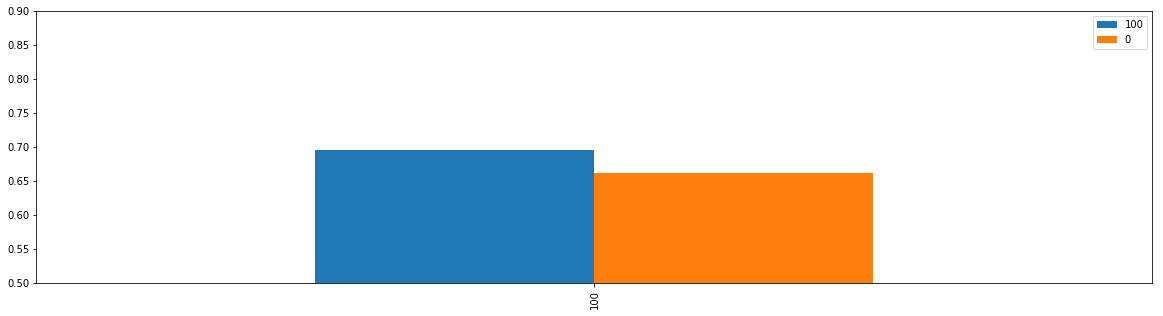

In [27]:
df10.plot(kind='bar', figsize = (20,5), ylim=(0.5,0.9))